In [1]:
import tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans, KShape, silhouette_score
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings('ignore')

In [2]:
import wandb
wandb.init(project="tscluster", entity="pillarxyz")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pillarxyz (use `wandb login --relogin` to force relogin)


In [3]:
seed = 0
np.random.seed(seed)

In [4]:
stocks_df = pd.read_csv("data/stocks.csv")

In [5]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,Aradei Capital,ATLANTASANAD,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,16/01/2017,54.87,822.5,315.35,NaN,NaN,128.00,1150.0,NaN,49.00,...,284.00,2350.0,56.99,804.0,276.00,1450.0,NaN,4850.0,122.00,12576.9549
1,17/01/2017,51.50,822.5,315.35,NaN,NaN,128.55,1150.0,NaN,49.40,...,284.00,2300.0,59.00,790.0,292.55,1402.0,NaN,4851.0,122.00,12343.0822
2,18/01/2017,52.00,823.0,320.00,NaN,NaN,130.00,1150.0,NaN,47.86,...,284.00,2300.0,60.50,790.0,292.50,1411.0,NaN,4800.0,122.00,12379.0624
3,19/01/2017,52.00,805.1,300.00,NaN,NaN,131.45,1180.0,NaN,49.90,...,283.85,2350.0,54.46,795.0,275.00,1478.0,NaN,4840.0,122.00,12425.0963
4,20/01/2017,53.00,830.0,295.00,NaN,2460.0,131.00,1150.0,NaN,49.00,...,283.85,2350.0,56.39,810.0,259.05,1499.0,NaN,4800.0,129.30,12592.5336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,12/01/2022,11.40,1350.0,345.00,5404.0,4550.0,39.00,1428.0,415.00,136.50,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560
1240,13/01/2022,11.58,1350.0,353.20,5351.0,4500.0,39.00,1425.0,419.95,135.85,...,147.00,2859.0,42.20,1140.0,141.00,1770.0,142.0,4571.0,80.02,13588.2416
1241,14/01/2022,11.52,1350.0,350.00,5410.0,4500.0,38.90,1425.0,420.00,136.00,...,147.00,2980.0,43.38,1162.0,141.00,1805.0,142.0,4845.0,80.02,13784.3063
1242,17/01/2022,11.51,1350.0,350.00,5410.0,4679.0,38.38,1424.0,422.10,134.00,...,147.00,2980.0,43.33,1215.0,141.00,1800.0,142.0,4845.0,80.02,13770.7843


In [6]:
stocks_df.date = pd.to_datetime(stocks_df.date, format='%d/%m/%Y')

In [7]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

SAMIR             100.000000
Diac Salaf        100.000000
Aradei Capital     77.974277
Mutandis           38.424437
Immr Invest        26.848875
Nexans Maroc        2.733119
Unimer              2.652733
BALIMA              2.250804
Rebab Company       2.170418
Agma                1.929260
Maroc Leasing       1.607717
Auto Nejma          1.446945
Oulmes              1.366559
Afriquia Gaz        1.045016
Maghrebail          1.045016
dtype: float64

In [8]:
stocks_df.drop(columns = ["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"], inplace = True)

In [9]:
stocks_df = stocks_df.ffill()
stocks_df = stocks_df.bfill()

In [10]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

date               0.0
Med Paper          0.0
Res.Dar Saada      0.0
Rebab Company      0.0
PROMOPHARM         0.0
Oulmes             0.0
Nexans Maroc       0.0
Microdata          0.0
Maroc Telecom      0.0
S2M                0.0
Maroc Leasing      0.0
Managem            0.0
Maghrebail         0.0
Maghreb Oxygene    0.0
M2M Group          0.0
dtype: float64

In [11]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,2017-01-16,54.87,822.5,315.35,2690.0,2460.0,128.00,1150.0,49.00,440.0,...,284.00,2350.0,56.99,804.0,276.00,1450.0,180.0,4850.0,122.00,12576.9549
1,2017-01-17,51.50,822.5,315.35,2690.0,2460.0,128.55,1150.0,49.40,418.5,...,284.00,2300.0,59.00,790.0,292.55,1402.0,180.0,4851.0,122.00,12343.0822
2,2017-01-18,52.00,823.0,320.00,2690.0,2460.0,130.00,1150.0,47.86,430.0,...,284.00,2300.0,60.50,790.0,292.50,1411.0,180.0,4800.0,122.00,12379.0624
3,2017-01-19,52.00,805.1,300.00,2690.0,2460.0,131.45,1180.0,49.90,433.0,...,283.85,2350.0,54.46,795.0,275.00,1478.0,180.0,4840.0,122.00,12425.0963
4,2017-01-20,53.00,830.0,295.00,2690.0,2460.0,131.00,1150.0,49.00,435.0,...,283.85,2350.0,56.39,810.0,259.05,1499.0,180.0,4800.0,129.30,12592.5336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,2022-01-12,11.40,1350.0,345.00,5404.0,4550.0,39.00,1428.0,136.50,491.0,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560
1240,2022-01-13,11.58,1350.0,353.20,5351.0,4500.0,39.00,1425.0,135.85,490.6,...,147.00,2859.0,42.20,1140.0,141.00,1770.0,142.0,4571.0,80.02,13588.2416
1241,2022-01-14,11.52,1350.0,350.00,5410.0,4500.0,38.90,1425.0,136.00,498.0,...,147.00,2980.0,43.38,1162.0,141.00,1805.0,142.0,4845.0,80.02,13784.3063
1242,2022-01-17,11.51,1350.0,350.00,5410.0,4679.0,38.38,1424.0,134.00,495.0,...,147.00,2980.0,43.33,1215.0,141.00,1800.0,142.0,4845.0,80.02,13770.7843


In [12]:
stocks_df = stocks_df[(stocks_df["date"] > '2017-01-01')].reset_index(drop = True)

In [13]:
stocks_df = stocks_df.resample('7D', on = 'date').first().reset_index(drop = True)

In [14]:
stocks_df.index = stocks_df.date

In [15]:
stocks_df.drop("date", axis = 1, inplace = True)

In [16]:
stocks_df

,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,Auto Hall,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,54.87,822.5,315.35,2690.0,2460.0,128.00,1150.0,49.00,440.00,115.15,...,284.00,2350.0,56.99,804.0,276.00,1450.0,180.0,4850.0,122.00,12576.9549
2017-01-23,52.70,830.0,295.00,2690.0,2460.0,129.50,1218.0,49.05,428.00,115.90,...,280.00,2350.0,53.30,805.0,260.00,1500.0,180.0,4800.0,137.05,12500.0500
2017-01-30,49.00,840.0,300.00,2650.0,2465.0,121.00,1299.0,48.11,427.00,116.00,...,277.00,2300.0,54.30,799.2,258.55,1500.0,180.0,4940.0,140.00,12385.2062
2017-02-06,48.00,866.0,301.00,2600.0,2490.0,120.00,1300.0,49.18,428.95,114.90,...,283.70,2300.0,50.00,805.0,214.80,1500.0,180.0,4800.0,140.00,12247.6579
2017-02-13,51.65,840.0,300.00,2755.0,2342.0,163.50,1230.0,48.45,440.00,115.00,...,330.00,2350.0,50.24,802.0,255.45,1550.0,180.0,4950.0,141.00,12367.7648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,10.70,1319.0,345.00,5110.0,4400.0,39.10,1400.0,115.00,478.05,105.50,...,148.00,2801.0,39.01,1100.0,138.00,1760.0,141.4,4700.0,80.00,13253.9624
2021-12-27,11.00,1319.0,343.00,5285.0,4321.0,39.45,1389.0,117.60,479.95,105.00,...,148.00,2845.0,37.60,1100.0,137.90,1750.0,141.4,4700.0,80.00,13236.3867
2022-01-03,10.63,1360.0,343.00,5300.0,4730.0,36.50,1392.0,120.00,480.50,103.00,...,151.45,2860.0,39.30,1053.0,137.90,1720.0,141.4,4850.0,74.00,13296.2891


In [17]:
stocks = stocks_df

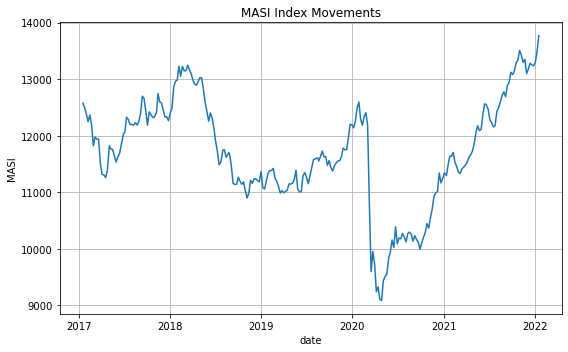

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(stocks_df.index, stocks_df["MASI"])
ax.grid()
ax.set_title('MASI Index Movements')
ax.set_ylabel('MASI')
ax.set_xlabel('date')
fig.tight_layout();

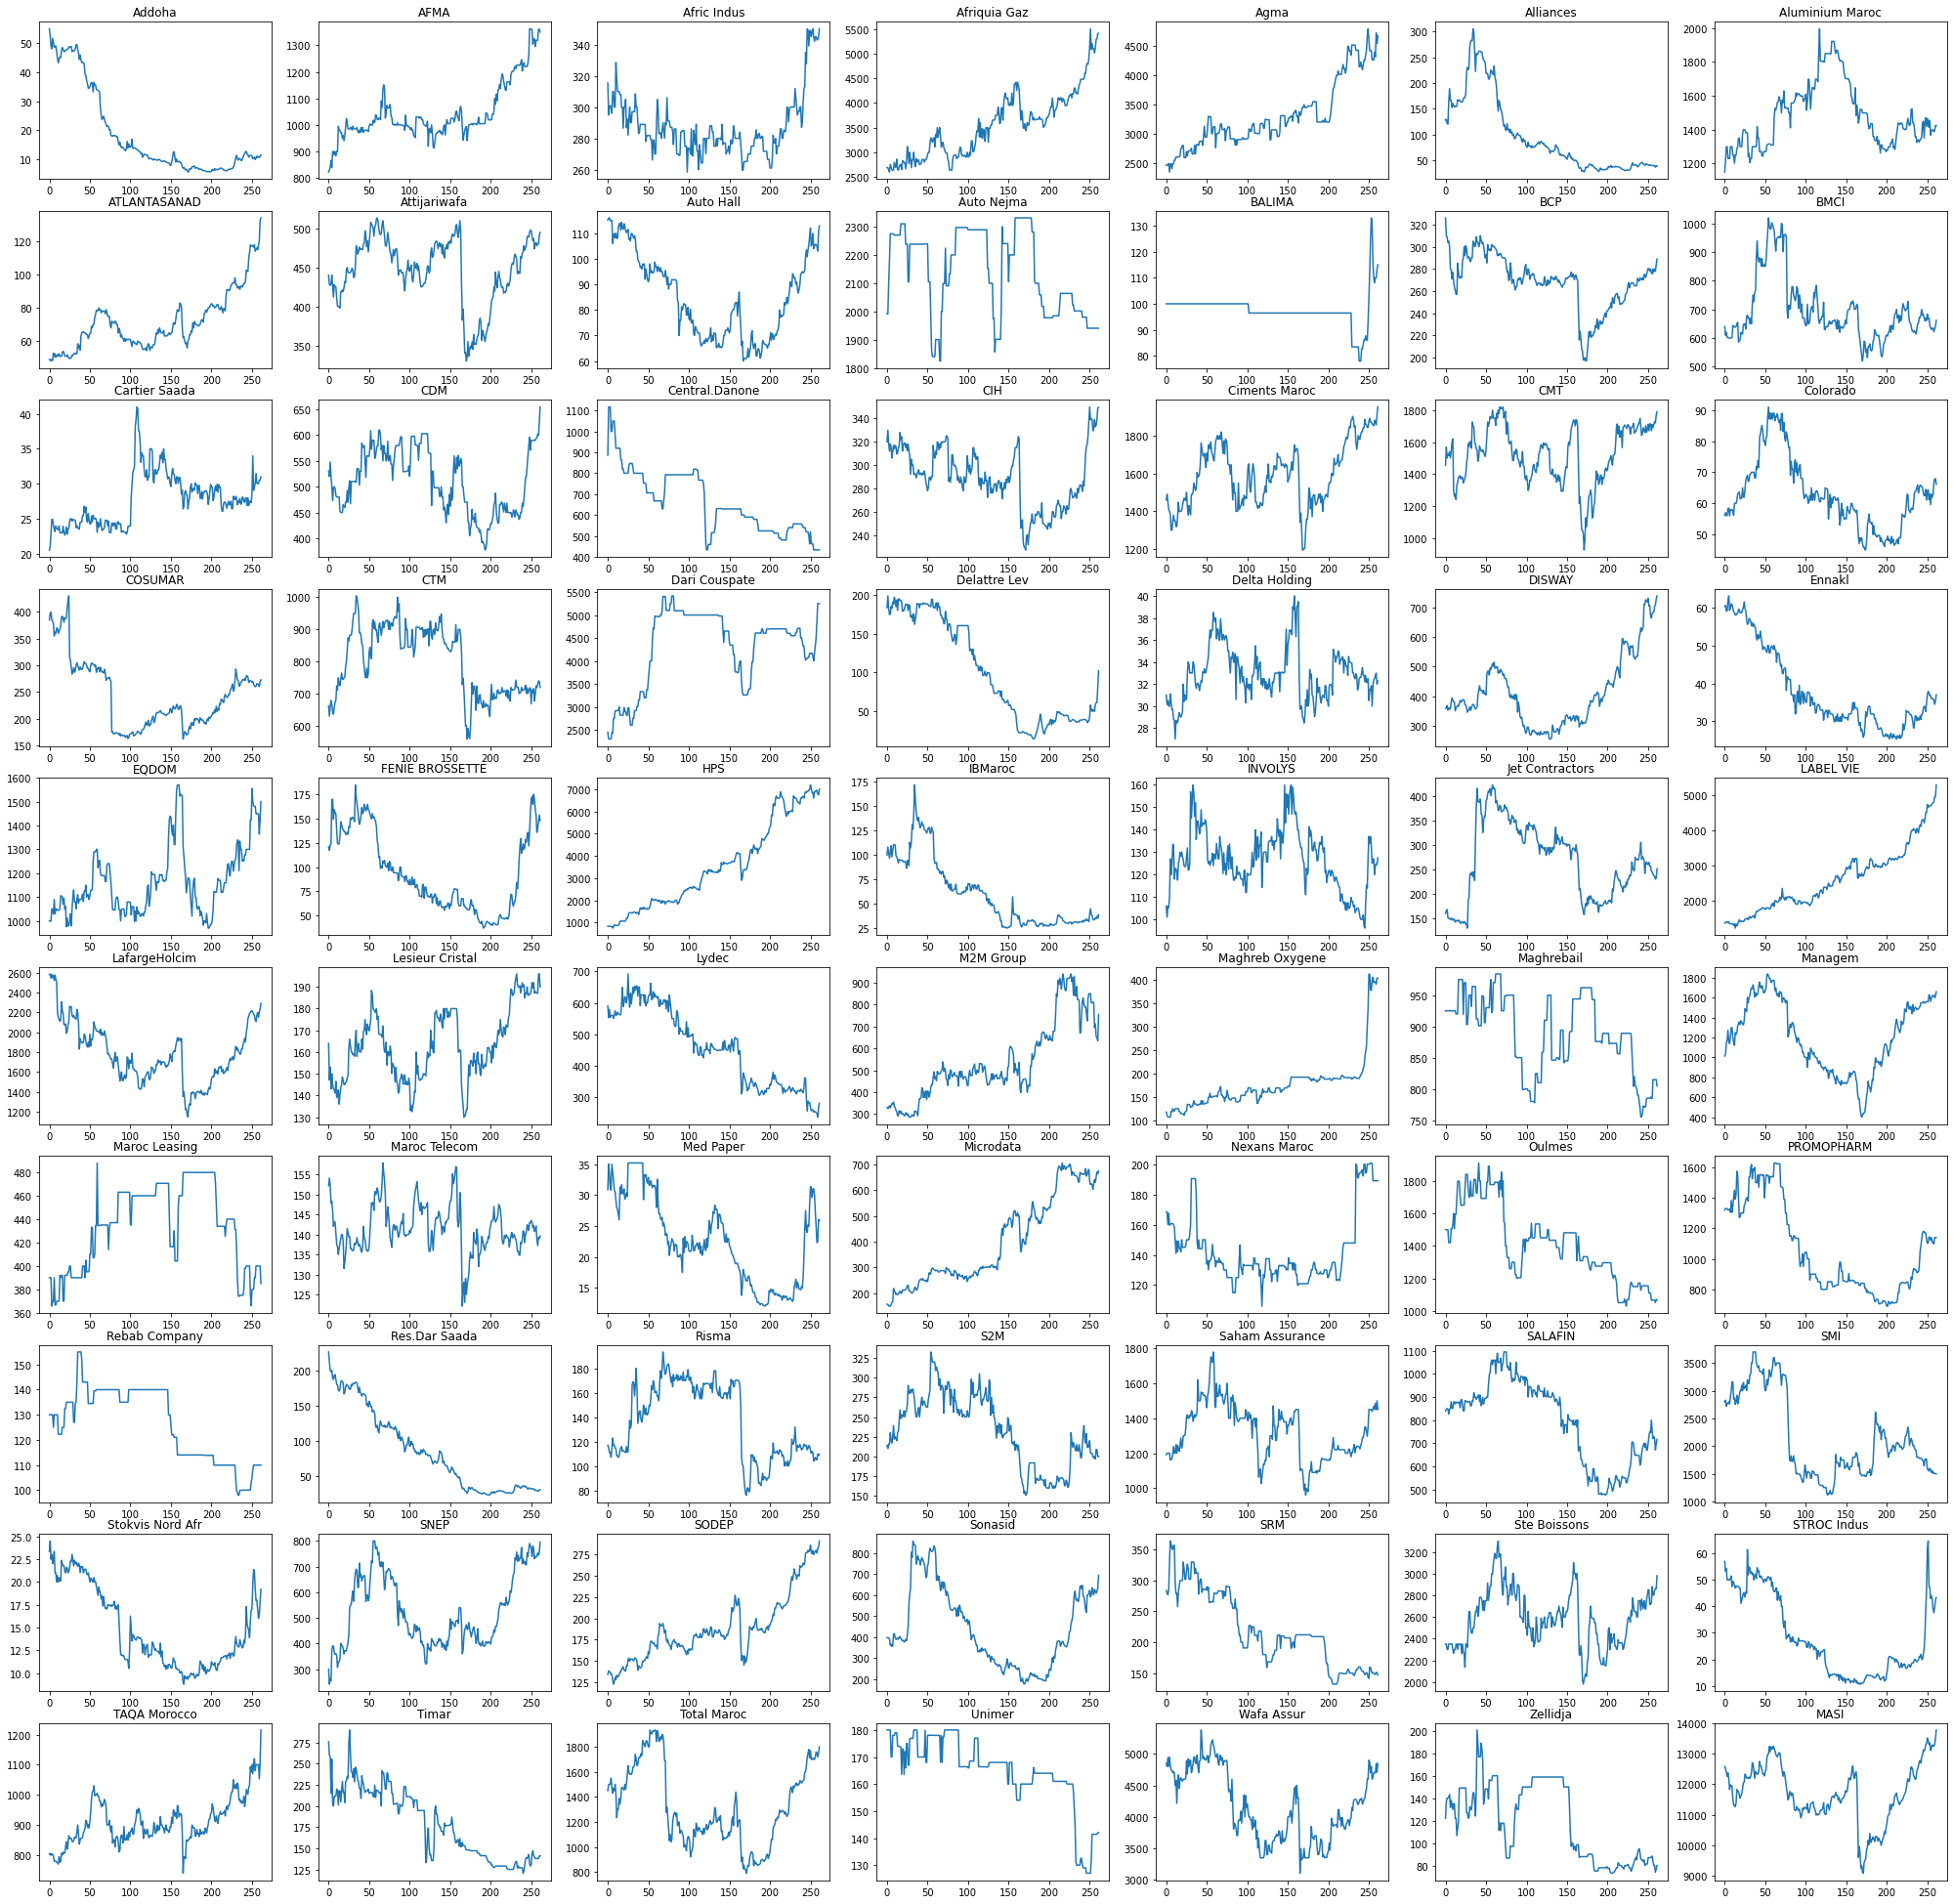

In [19]:
cols = stocks_df.columns

fig, axs = plt.subplots(10,7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        axs[i, j].plot(stocks_df[cols[i*7+j]].values)
        axs[i, j].set_title(cols[i*7+j])
plt.show()

In [20]:
stocks_df.T

date,2017-01-16,2017-01-23,2017-01-30,2017-02-06,2017-02-13,2017-02-20,2017-02-27,2017-03-06,2017-03-13,2017-03-20,...,2021-11-15,2021-11-22,2021-11-29,2021-12-06,2021-12-13,2021-12-20,2021-12-27,2022-01-03,2022-01-10,2022-01-17
Addoha,54.8700,52.70,49.0000,48.0000,51.6500,49.9800,48.5000,48.9600,48.9800,47.0000,...,10.6000,10.7900,10.0000,10.5100,11.2000,10.7000,11.0000,10.6300,11.0100,11.5100
AFMA,822.5000,830.00,840.0000,866.0000,840.0000,900.0000,899.9000,887.0000,900.0000,883.5000,...,1304.0000,1324.0000,1325.0000,1295.0000,1319.0000,1319.0000,1319.0000,1360.0000,1361.0000,1350.0000
Afric Indus,315.3500,295.00,300.0000,301.0000,300.0000,296.0000,310.0000,309.8000,300.0000,300.0000,...,348.0000,350.0000,344.8000,342.0000,345.0000,345.0000,343.0000,343.0000,345.0000,350.0000
Afriquia Gaz,2690.0000,2690.00,2650.0000,2600.0000,2755.0000,2700.0000,2650.0000,2630.0000,2650.0000,2790.0000,...,5082.0000,5206.0000,5100.0000,5100.0000,5011.0000,5110.0000,5285.0000,5300.0000,5404.0000,5410.0000
Agma,2460.0000,2460.00,2465.0000,2490.0000,2342.0000,2475.0000,2489.0000,2400.0000,2480.0000,2489.0000,...,4425.0000,4425.0000,4266.0000,4266.0000,4266.0000,4400.0000,4321.0000,4730.0000,4550.0000,4679.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Total Maroc,1450.0000,1500.00,1500.0000,1500.0000,1550.0000,1480.0000,1430.0000,1470.0000,1449.0000,1500.0000,...,1700.0000,1710.0000,1700.0000,1700.0000,1720.0000,1760.0000,1750.0000,1720.0000,1750.0000,1800.0000
Unimer,180.0000,180.00,180.0000,180.0000,180.0000,170.0000,170.0000,178.0000,178.0000,178.0000,...,132.0500,141.4000,141.4000,141.4000,141.4000,141.4000,141.4000,141.4000,142.0000,142.0000
Wafa Assur,4850.0000,4800.00,4940.0000,4800.0000,4950.0000,4819.0000,4745.0000,4739.0000,4700.0000,4720.0000,...,4700.0000,4800.0000,4600.0000,4630.0000,4700.0000,4700.0000,4700.0000,4850.0000,4707.0000,4845.0000
Zellidja,122.0000,137.05,140.0000,140.0000,141.0000,143.1500,131.7000,138.0000,135.0000,129.7500,...,87.0000,87.0000,87.5000,88.3300,83.4800,80.0000,80.0000,74.0000,76.9500,80.0200


In [21]:
ts = np.array(stocks_df.T).reshape(stocks_df.T.shape[0], stocks_df.T.shape[1], 1)
ts = TimeSeriesScalerMinMax().fit_transform(ts)

In [22]:
km = TimeSeriesKMeans(n_clusters = 5, random_state = seed, metric = 'dtw')
y_pred = km.fit_predict(ts)
s = silhouette_score(ts, y_pred, metric="dtw")
print("K-means metrics : ")
print(f"Silhouette score = {s}, \nInertia = {km.inertia_}")

K-means metrics : 
Silhouette score = 0.3037558478952608, 
Inertia = 0.9104762895214457


In [23]:
wandb.run.summary["n_clusters"] = km.n_clusters
wandb.run.summary["silhouette_score"] = s
wandb.run.summary["Inertia"] = km.inertia_

In [24]:
clusters_df = pd.DataFrame({'Company\'s stock':stocks_df.columns, 'Cluster': y_pred})

In [25]:
clusters_df

,Company's stock,Cluster
0,Addoha,3
1,AFMA,2
2,Afric Indus,4
3,Afriquia Gaz,2
4,Agma,2
...,...,...
65,Total Maroc,4
66,Unimer,3
67,Wafa Assur,4
68,Zellidja,3


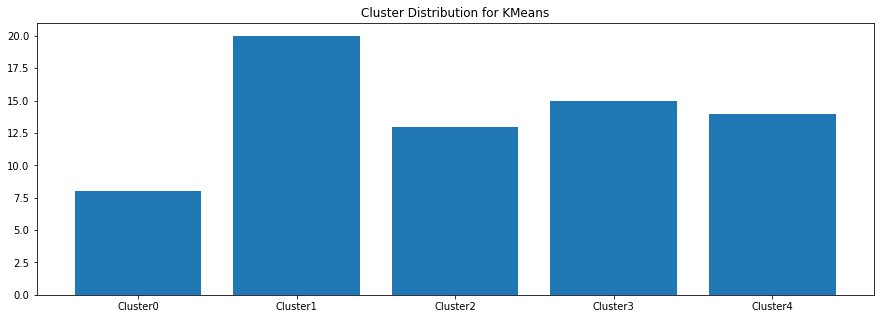

In [26]:
cluster_c = clusters_df["Cluster"].value_counts().sort_index()
cluster_n = [f"Cluster{str(i)}" for i in range(km.n_clusters)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n, cluster_c)
plt.show()

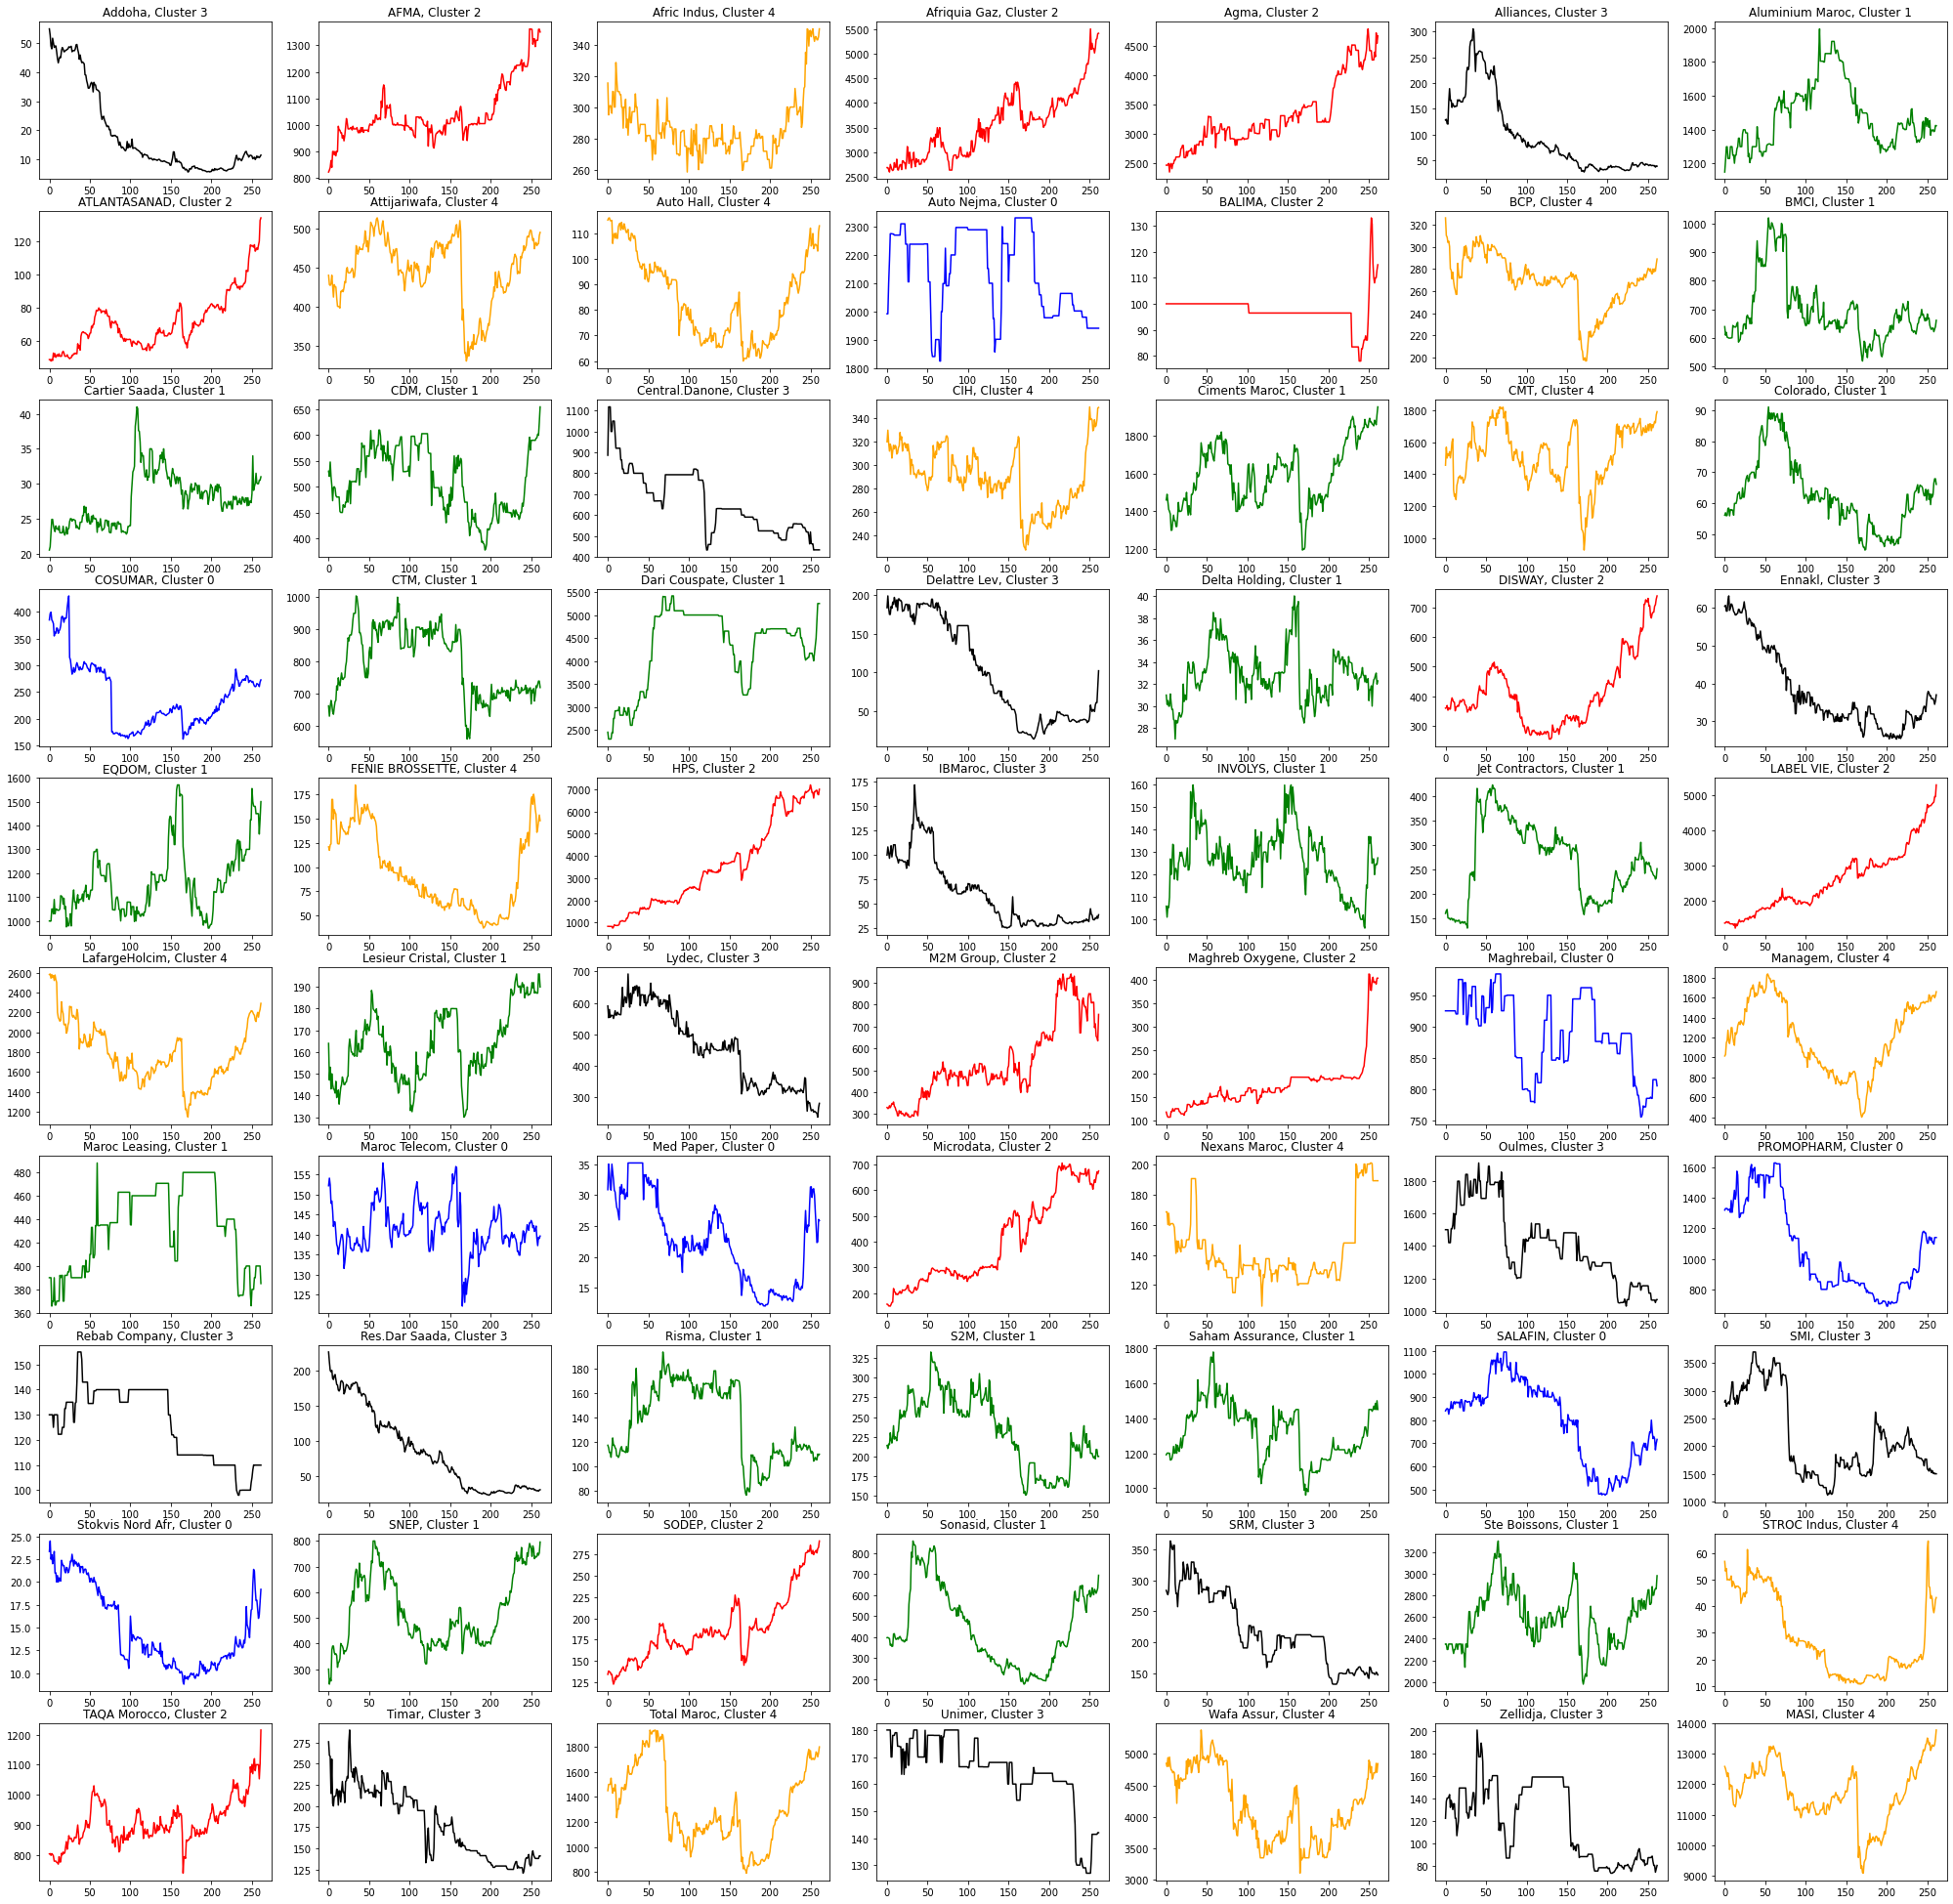

In [27]:
colors = ['b', 'g','r', 'k', 'orange']

fig, ax = plt.subplots(10, 7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        ax[i, j].plot(stocks_df[cols[i*7+j]].values, color = colors[y_pred[i*7+j]])
        ax[i, j].set_title(f"{cols[i*7+j]}, Cluster {y_pred[i*7+j]}")
plt.show()